In [2]:
from SimPEG import *
from simpegPF.MagAnalytics import spheremodel, MagSphereAnaFun, CongruousMagBC, MagSphereAnaFunA
from simpegPF.Magnetics import MagneticsDiffSecondary, MagneticsDiffSecondaryInv, BaseMag
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16, 'text.usetex': True})

# Forward problem: Magnetics

This is a tutorial for Mag forward problem using simpegPF package. We first start with analytic solution for susceptible sphere in a whole space. Then we solve steady-state Maxwell's equatoins for Mag problem (<a href="http://simpegpf.readthedocs.org/en/latest/api_PF.html">See Doc</a>) using simpegPF package. 

## Step1: Discretize the earth

We use TensorMesh class in SimPEG to discretize the 3D earth (<a href="http://docs.simpeg.xyz/en/latest/api_MeshCode.html?highlight=tensormesh#module-SimPEG.Mesh.TensorMesh">See Doc</a>). Let's visualize discretized mesh on section views:

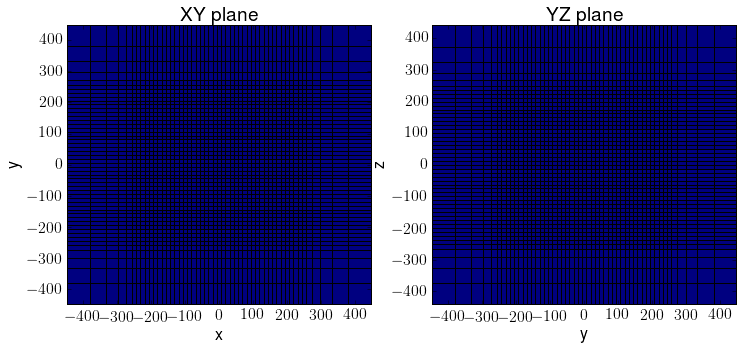

In [4]:
cs = 12.5
ncx, ncy, ncz, npad = 41, 41, 40, 5
hx = [(cs,npad,-1.4), (cs,ncx), (cs,npad,1.4)]
hy = [(cs,npad,-1.4), (cs,ncy), (cs,npad,1.4)]
hz = [(cs,npad,-1.4), (cs,ncz), (cs,npad,1.4)]
mesh = Mesh.TensorMesh([hx, hy, hz], 'CCC')
fig, ax = plt.subplots(1,2, figsize=(12, 5))
dat0 = mesh.plotSlice(np.zeros(mesh.nC), grid=True, ax=ax[0]); ax[0].set_title('XY plane')
dat1 = mesh.plotSlice(np.zeros(mesh.nC), grid=True, normal='X', ax=ax[1]); ax[1].set_title('YZ plane')

## Step2: Compose suceptibility model: susceptible sphere in whole space

- $\mu = \mu_0(1+\chi)$
- $\mu$: magnetic permeability
- $\mu_0$: magnetic permeability of vacuum space
- $\chi$: magnetic susceptibility

In [5]:
from scipy.constants import mu_0
mu0 = 4*np.pi*1e-7
chibkg = 0.     # Background susceptibility
chiblk = 0.01   # Susceptibility for a sphere
chi = np.ones(mesh.nC)*chibkg

In [6]:
sph_ind = spheremodel(mesh, 0, 0, -100, 80) # A sphere is located at (0, 0, 0) and radius of the sphere is 100 m
chi[sph_ind] = chiblk # Assign susceptibility value for the sphere
mu = (1.+chi)*mu0

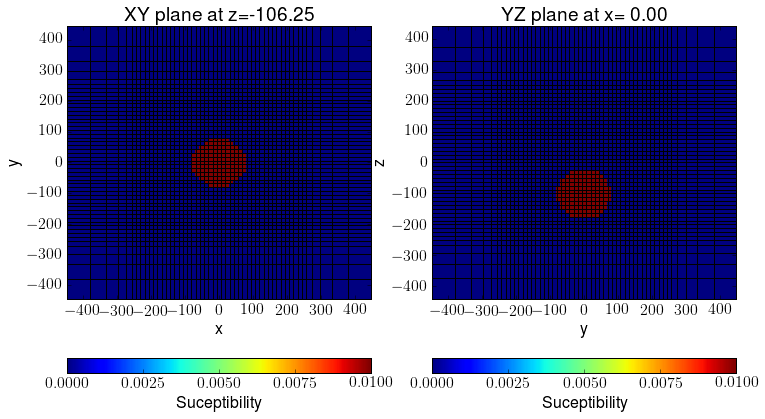

In [7]:
fig, ax  =  plt.subplots(1,2, figsize=(12, 7))
indz = int(np.argmin(abs(mesh.vectorCCz-(-100.)))); indx = int(np.argmin(abs(mesh.vectorCCx-0.)))
dat0 = mesh.plotSlice(chi, grid=True, ind=indz, ax=ax[0]); ax[0].set_title(('XY plane at z=%5.2f')%(mesh.vectorCCz[indz]))
dat1 = mesh.plotSlice(chi, grid=True, normal='X', ind=indx, ax=ax[1]); ax[1].set_title(('YZ plane at x=%5.2f')%(mesh.vectorCCx[indx]))
cb0 = plt.colorbar(dat0[0], orientation='horizontal',  ax=ax[0], ticks = linspace(0, 0.01, 5)); 
cb1 = plt.colorbar(dat1[0], orientation='horizontal',  ax=ax[1], ticks = linspace(0, 0.01, 5)); 
cb0.set_label("Suceptibility")
cb1.set_label("Suceptibility")

## Step3: Set up an airborne MAG survey

We have discretized 3D earth and generated suceptibility model, which means that we have discretized earth and physical property distribution. We can compute magnetic fields everywhere in our domain by solving parial differental equation (PDE), but our measurements are confined to finite locations. Therefore, we need to project computed fields $\mathbf{u}$, which is defined everywhere in our domain to certain locations where we have receiving points. For instance in airborne mag survey these are the points where a plane or helicopter measure earth magnetic fields. This projection can be expressed as:

$$ \mathbf{d} = P(\mathbf{u})$$

where $P(\cdot)$ is a projection from computed field to the measured data, and $d$ is the measure data. 

Let's assume that we have a survey area: 400 m $\times$ 400 m. We have 21 lines of airborne MAG survey, and we measure magnetic fields for every 20 m on each line. A pilot for this helicopter is really talented so that the flight height is constant for 30 m above the surface.  

In [8]:
xr = np.linspace(-200, 200, 21)
yr = np.linspace(-200, 200, 21)
X, Y = np.meshgrid(xr, yr)
Z = np.ones((size(xr), size(yr)))*30.

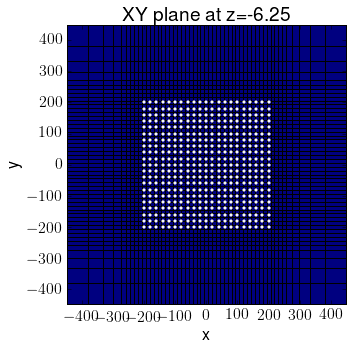

In [9]:
fig, ax  =  plt.subplots(1,1, figsize=(5, 5))
indz = int(np.argmin(abs(mesh.vectorCCz-(0.))));
dat0 = mesh.plotSlice(chi, grid=True, ind=indz, ax=ax); ax.set_title(('XY plane at z=%5.2f')%(mesh.vectorCCz[indz]))
ax.plot(X.flatten(), Y.flatten(), 'w.', ms=5)

## Step4: Analytic solution

We have an analytic solution when we have a sphere in a whole-space. simpegPF provides this function so that you can compute magnetic field on your receiving locations. Another input you need to put is direction of the earth magnetic fieds, and the strength, you can easily get this information from <a href="http://www.ngdc.noaa.gov/geomag-web/">NOAA's website</a>. We assume that we have veritcal earth fields and the strength is 1. 

In [12]:
Bxra, Byra, Bzra = MagSphereAnaFunA(X, Y, Z, 80., 0., 0., -100, chiblk, np.array([0., 0., 1.]), flag)
Bxra = np.reshape(Bxra, (size(xr), size(yr)), order='F')
Byra = np.reshape(Byra, (size(xr), size(yr)), order='F')
Bzra = np.reshape(Bzra, (size(xr), size(yr)), order='F')

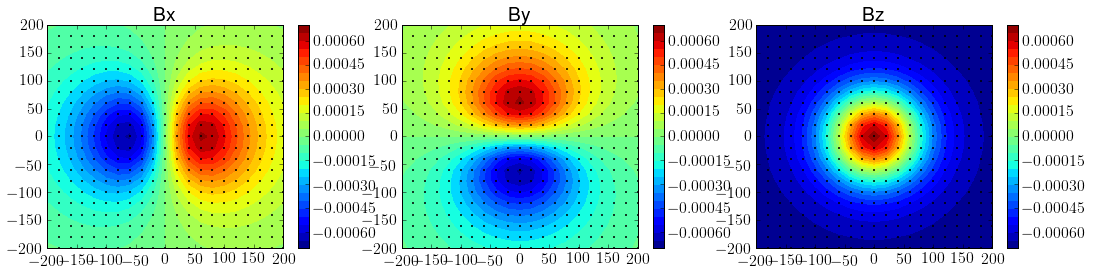

In [13]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))
dat0=ax[0].contourf(X, Y, Bxra, 30); ax[0].set_title('Bx'); cb0 = plt.colorbar(dat0, ax=ax[0])
dat1=ax[1].contourf(X, Y, Byra, 30); ax[1].set_title('By'); cb1 = plt.colorbar(dat0, ax=ax[1])
dat2=ax[2].contourf(X, Y, Bzra, 30); ax[2].set_title('Bz'); cb2 = plt.colorbar(dat0, ax=ax[2])
for i in range(3):
    ax[i].plot(X.flatten(), Y.flatten(), 'k.', ms=3)

## Step5: Solve PDE

Note that data for this case magnetic fields projected to earth field direction, which is typical data type for airborne mag survey. 

First, set survey class

In [ ]:
survey = BaseMag.BaseMagSurvey() # survey class for mag problem
Inc = 90.
Dec = 0.
Btot = 1
survey.setBackgroundField(Inc, Dec, Btot) # set inclination, declination, and strength of magnetic field
rxLoc = np.c_[Utils.mkvc(X), Utils.mkvc(Y), Utils.mkvc(Z)]
survey.rxLoc = rxLoc # set receiver locations

Second, set problem class then pair with survey

In [ ]:
prob = MagneticsDiffSecondary(mesh)
prob.pair(survey)

Third, run forward modeling

In [ ]:
data = survey.dpred(mu)

Now we viualize computed solution and compare with analytic solutions! Note that you may always need to make sure that your numerical solution is reasonable enough. 

NameError: name 'Bzra' is not defined

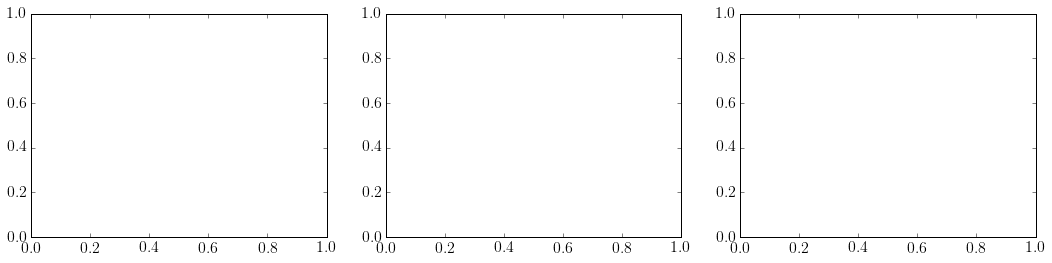

In [11]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))
vmin = Bzra.min()
vmax = Bzra.max()
residual = data.reshape((xr.size, yr.size), order='F')-Bzra
dat0=ax[0].contourf(X, Y, Bzra, 30, vmin=vmin, vmax=vmax)
dat1=ax[1].contourf(X, Y, data.reshape((xr.size, yr.size), order='F'), 30, vmin=vmin, vmax=vmax)
dat2=ax[2].contourf(X, Y, residual, 30)
cb0 = plt.colorbar(dat0, ax=ax[0])
cb1 = plt.colorbar(dat0, ax=ax[1])
cb2 = plt.colorbar(dat2, ax=ax[2])
ax[0].set_title('Bz (analytic)')
ax[1].set_title('Bz (simpegPF)')
ax[2].set_title('Residual')

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.